In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from lifelines import ExponentialFitter # https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html#
from datetime import timedelta
from scipy.stats import bootstrap

# Summary выводов

Какие показатели RoAS[n], CPA[n] (n = 1, 3, 7, 30 дней) нужны для того, чтобы трафик окупился на 100% на 365-ый день (RoAS[365] = 1) в каждом из сегментов B0 ... B12

По метрике RoAS и CPA за первые 30 дней примерно оценить окупаемость канала можно при помощи матрицы эффективности, изображенной ниже на графиках, там же и диапазоны значений для которых означает, что трафик окупится. Чем правее и выше находится канал привлечения на осях - тем выше вероятность того, что он окупится.

Основной недостаток матрицы - она не учитывает ожидаемый срок жизни пользователей, поэтому дополнительно я построил модель "выживаемости" платящих пользователей, которая валидирует и дополняет результаты оценки на базе матриц (оценка RoAS представлена ниже матриц).

Что видно из матрицы:
- `B3, B2, B9, B10` с самого первого дня вырвались вперед - у них самые высокие показатели RoAS[1-30 days] и самые низкие CPA. Прогноз по RoAS[365 days] - 1.75, 2.15, 2.12, 2.68, это одни из самых высоких показателей среди всех каналов привлечения. **Recommendation: продолжать инвестировать в данные каналы привлечения**
- `B5, B11` - с первого дня показывают одни из самых низких показателей RoAS при довольно средних значениях CPA, однако, окупаемости по данным каналам на 365 день не наступит, это видно из матрицы эффективности и анализа выживаемости. Основной фактор - низкая доля платящих пользователей. **Recommendation: необходимо проработать варианты работы с оттоком, а также коммуникации для активных игроков, кто еще не совершал покупки (подробнее рассказать про возможности, предложить скидку на первую покупку)**
- `B0, B1` - два самых дорогих канала привлечения, но со средними показателями RoAS[1-30 days], также важно отметить, что B0 - это самый массовый канал по количеству установок. Матрица дает противоречивую оценку и однозначно сказать про окупаемость нельзя, но модель "выживаемости" для этих каналов дает оптимистичный прогноз об их окупаемости, основным фактором, который играет вверх, является довольно высокая доля платящих пользователей в обоих каналах и высокий ARPPU. **Recommendation: необходимо проработать варианты работы с текущей платящей аудиторией для увеличения Retention (например бонусы игрокам, потратившим более определенной суммы)**
- `B4, B6, B7, B8` - середнячки, каналы наиболее вероятно, что достигнут окупаемости за 365 дней, это подтверждается их положением в матрице и моделью "выживаемости". **Recommendation: необходимо проработать варианты работы с текущей платящей аудиторией для увеличения Retention**
- Отдельно я выделю `B12` - канал со средними показателями RoAS и CPA, но одним из самых низких показателей доли платящих пользователей и ARPPU, при этом это канал с самым низким количеством установок, из-за чего модель выживаемости предсказывает то, что он не окупится за 365 дней. **Recommendation: необходимо проверить настройки таргетинга - возможно взят слишком узкий сегмент**


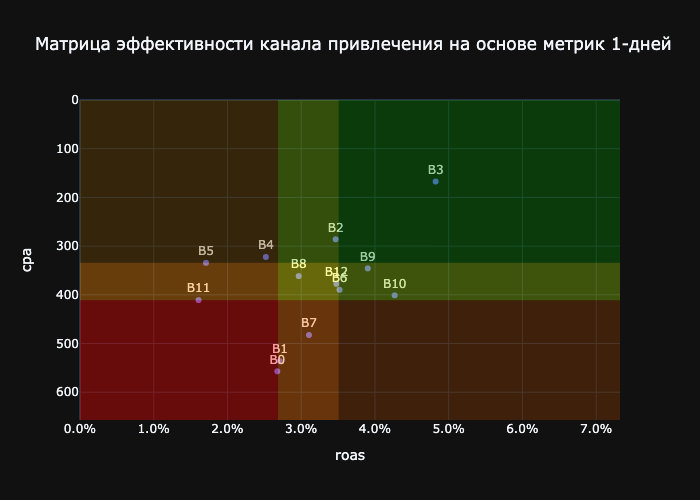

In [353]:
matrix(roas, cpa, 1).show('png')

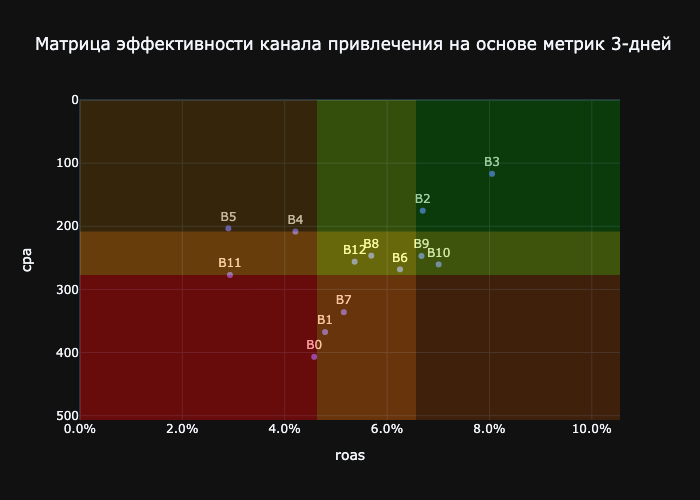

In [352]:
matrix(roas, cpa, 3).show('png')

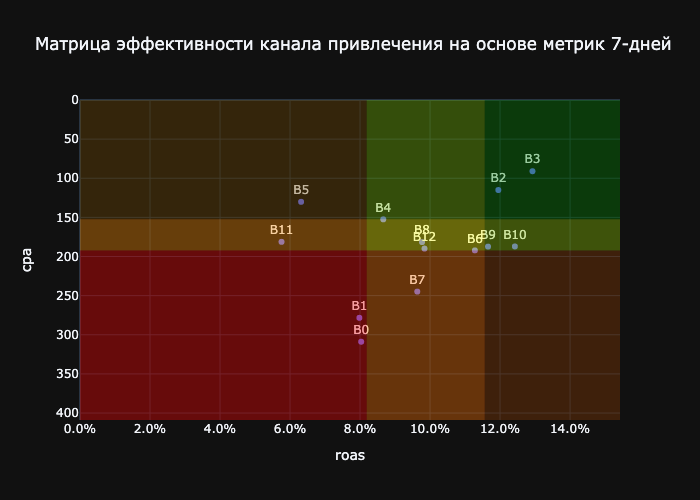

In [351]:
matrix(roas, cpa, 7).show('png')

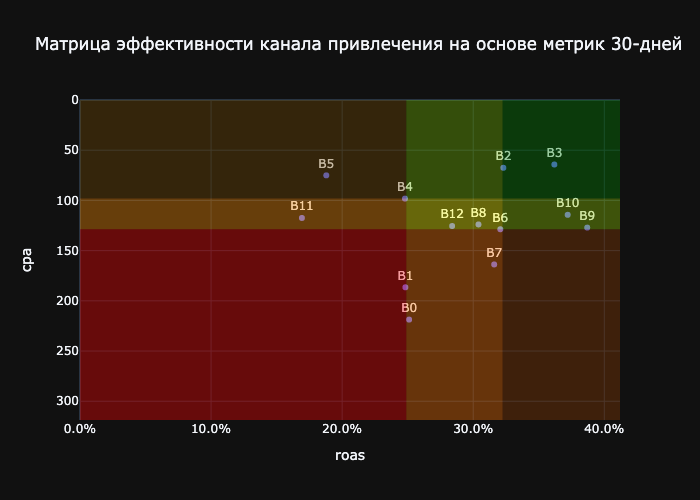

In [350]:
matrix(roas, cpa, 30).show('png')

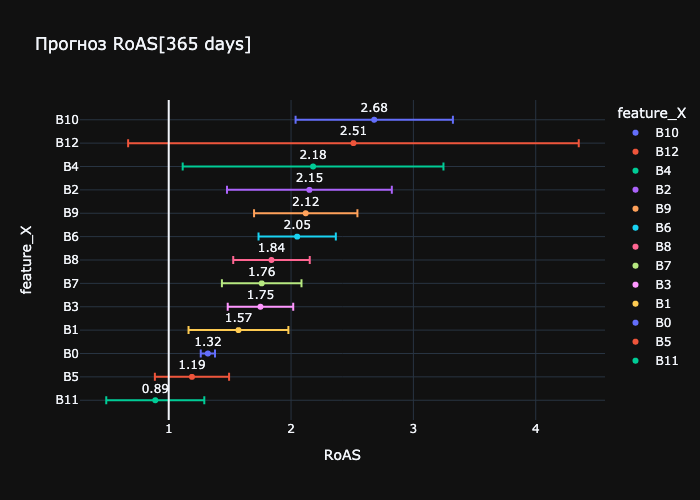

In [358]:
fig.show('png')

Какое количество инсталлов или платящих игроков Вы бы назвали достаточным для принятия решения, что трафик окупается / не окупается в каждом из сегментов по каждой из метрик (RoAS[n], CPA[n])?

Количество инсталлов не влияет на окупаемость канала напрямую, на окупаемость может влиять только конверсия установки в платящего пользователя, его retention и ARPPU, т.е. своего рода "качество инсталла".


Что мы могли скрыть под feature_X?

Мне кажется, что это могут быть площадки, на которых размещалась реклама. Например, B0, как самый большой, Facebook+Instagram, B3 - второй по размеру, Twitter

# Next steps

В качестве следующих шагов я выделю 2 направления:
1. Рост retention и ARPPU:
    - Во-первых, согласно разработанным рекомендациям выше, можно собрать дополнительные данные по действиям пользователя в игре и провести более детальный анализ причин, которые влияют на модель выживаемости платящих пользователей и подобрать оптимальные пути воздействия на пользователей для увеличения их retention
    - Во-вторых, для более эффективных коммуникаций можно применить подходы uplift-modeling и разделить пользователей на тех, кто в терминологии маркетинга называется "убеждаемый" - на них коммуникации будут воздействовать максимальным образом, а также лояльных - на кого можно не воздействовать, он и так купит и тех, кого не нужно беспокоить
2. Увеличение точности прогноза выручки пользователя за его срок жизни - поскольку у меня не было данных о клик-стриме и взаимодействие с продуктом мне пришлось использовать самую простую модель для прогноза retention, при наличии большего количества данных можно выстроить более детальную модель для прогнозирования срока жизни пользователя и выручки, которую он принесет компании на основе продуктовых данных

# Подготовка данных

В данном блоке я выгружаю данные из csv файлов и смотрю базовую информацию

## Загрузка данных и предобработка

In [2]:
users_df = pd.read_csv('./test_task_data/users.csv', names=['id', 'reg_time', 'feature_X', 'cpi'])
users_df.reg_time = pd.to_datetime(users_df.reg_time)
users_df.head()

,id,reg_time,feature_X,cpi
0,a1f3165713e2609ccfa94ac152745de9,2020-08-10 16:13:40,B10,0.68
1,65b3c06b73746ce96c985b2de163cb30,2020-08-10 16:14:11,B0,11.45
2,053713745bc236aaabeaeda33935f4e2,2020-08-10 16:14:49,B8,4.24
3,1fdec2d9affbab8b6c5d357f1e3a4e06,2020-08-10 16:15:19,B0,10.82
4,9f6fe54133cf4bcb55442499453d6e42,2020-08-10 16:16:44,B0,5.82


In [3]:
purchases_df = pd.read_csv('./test_task_data/purchases.csv', names=['id', 'buy_time', 'revenue'])
purchases_df.buy_time = pd.to_datetime(purchases_df.buy_time)
purchases_df.head()

,id,buy_time,revenue
0,3d41f57091f8653de23efb8e60ec8dd2,2020-08-22 10:03:53,0.867115
1,5af8d40efe885ac79ccc6b5a3f2da36e,2020-08-22 10:05:04,2.117543
2,ca9df5080da191e9bb231ce330ece9c6,2020-08-22 10:05:53,1.134119
3,ca9df5080da191e9bb231ce330ece9c6,2020-08-22 10:06:44,1.134119
4,5af8d40efe885ac79ccc6b5a3f2da36e,2020-08-22 10:06:53,5.305241


In [5]:
# Объединяем для дальнейших расчетов данные двух таблиц в одну
df = users_df.merge(
    purchases_df,
    on='id', how='left'
)
df.head()

,id,reg_time,feature_X,cpi,buy_time,revenue
0,a1f3165713e2609ccfa94ac152745de9,2020-08-10 16:13:40,B10,0.68,NaT,NaN
1,65b3c06b73746ce96c985b2de163cb30,2020-08-10 16:14:11,B0,11.45,NaT,NaN
2,053713745bc236aaabeaeda33935f4e2,2020-08-10 16:14:49,B8,4.24,NaT,NaN
3,1fdec2d9affbab8b6c5d357f1e3a4e06,2020-08-10 16:15:19,B0,10.82,NaT,NaN
4,9f6fe54133cf4bcb55442499453d6e42,2020-08-10 16:16:44,B0,5.82,NaT,NaN


## Users by feature_X

- Самый большой источник трафика `B0`, также это самый дорогой
- Второй по размеру канал - `B3`, при этом средняя цена привлечения в 5 раз ниже, чем у `B0`
- Самый дешевый канал - `B11`

In [4]:
users_df.groupby('feature_X').agg(
    avg_cpi=('cpi', 'mean'),
    median_cpi=('cpi', 'median'),
    percentile_90=('cpi', lambda x: np.percentile(x, 90)),
    spending=('cpi', 'sum'),
    users_num=('id', 'count')).sort_values('users_num', ascending=False)

,avg_cpi,median_cpi,percentile_90,spending,users_num
feature_X,,,,,
B0,9.838772,8.73,18.630,4636846.090,471283
B3,2.206681,1.68,4.340,246744.465,111817
B10,1.922740,1.66,3.320,107627.300,55976
B6,3.893421,3.44,7.450,191684.820,49233
B5,0.939824,0.79,1.470,44739.380,47604
B8,3.835697,3.29,7.200,161766.700,42174
B7,4.528985,4.03,8.300,186730.070,41230
B2,1.823320,1.28,3.730,63692.210,34932
B9,4.543666,3.89,8.720,130948.450,28820


# EDA

## Per day metrics

В данном разделе больше описательная часть,  несколько мыслей:
- У меня есть данные по установкам за 3 месяца - с августа по конец октября
- В среднем в день идет около 11к установок, при чем больше половины - это `B0`
- Данные по установкам сопровождаются данными о стоимости каждой установки, что позволяет посчитать общие расходы на кампанию
- Также у меня есть данные по покупкам, при чем на 2 месяца больше, чем по установкам
- Из сопоставления объемов выручки и расходов на привлечение видно, что окупаемость каждого инсталла занимаем не менее полугода, это растянутый процесс во времени

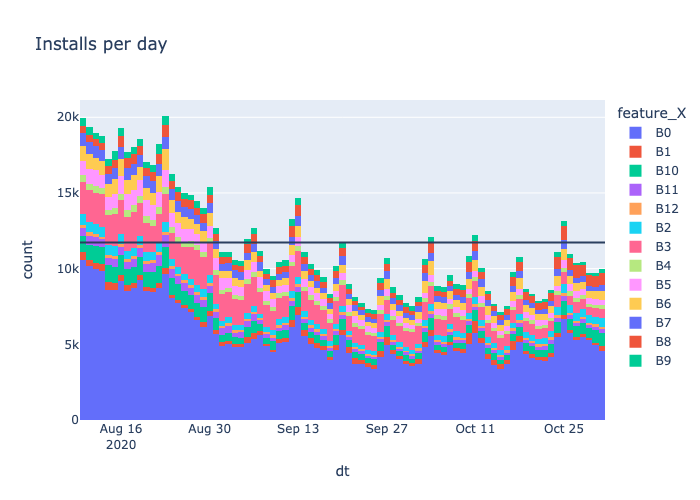

In [15]:
users_df['dt'] = users_df['reg_time'].dt.date
fig = px.histogram(
    users_df.sort_values(['feature_X', 'dt']),
    x='dt', color='feature_X',
    title='Installs per day'
)
fig.show('png')

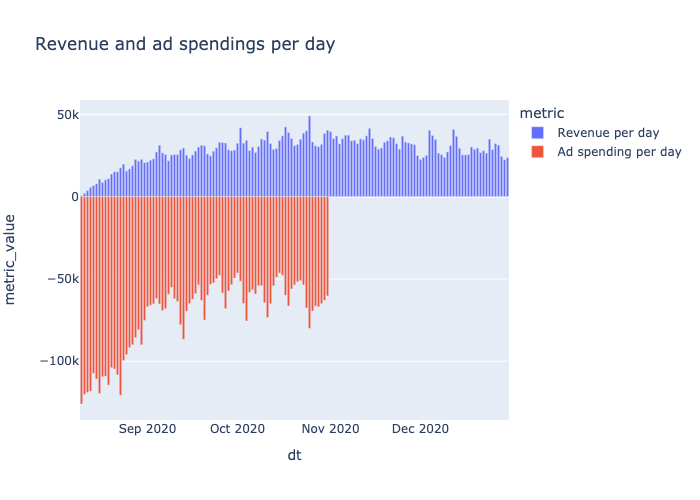

In [7]:
purchases_df['dt'] = purchases_df['buy_time'].dt.date
pnl = purchases_df.groupby('dt', as_index=False)['revenue'].sum().rename({'revenue': 'metric_value'}, axis=1)
pnl['metric'] = 'Revenue per day'
temp = users_df.groupby('dt')['cpi'].sum().apply(lambda x: x*-1).reset_index().rename({'cpi': 'metric_value'}, axis=1)
temp['metric'] = 'Ad spending per day'
pnl = pd.concat([pnl, temp])
del(temp)
fig = px.bar(
    pnl,
    x='dt', y='metric_value', color='metric', title='Revenue and ad spendings per day'
)
fig.show('png')
del(pnl)

## RoAS - revenue on ad spendings

RoAS[n] = RPI[n] / CPI, где RPI[n] - средний платеж пользователя за первые n дней игры, а CPI - средняя цена привлечения пользователя

In [257]:
df['lifetime_per_buy_time'] = (df['buy_time'] - df['reg_time']).dt.days
df['lifetime_per_buy_time'] = df['lifetime_per_buy_time'].fillna(0).astype(int)

roas = None
agg_func = {
    'feature_X': ('feature_X', 'first'),
    'cpi': ('cpi', 'first'),
    'revenue': ('revenue', 'sum')
}
days = [1, 3, 7, 30]
# days = range(1, 61)
for day in days:
    temp = df.loc[df.lifetime_per_buy_time <= day].groupby('id', as_index=False).agg(**agg_func)
    temp = temp.groupby('feature_X', as_index=False).agg(rpi=('revenue', 'mean'), cpi=('cpi', 'mean'))
    temp['roas'] = temp['rpi'] / temp['cpi']
    temp['day'] = day
    if roas is None:
        roas = temp
    else:
        roas = pd.concat([roas, temp])

temp = roas.groupby('day', as_index=False).mean()
temp['feature_X'] = 'mean'
roas = pd.concat([roas, temp])
del(temp)
# roas.pivot(index='feature_X', columns='day', values='roas').sort_values(30, ascending=False)
fig = px.line(
    roas.sort_values('day'),
    x='day', y='roas', color='feature_X',
    title='Revenue on Ad spendings - RoAS[day]',
    template='plotly_dark',
    height=800, width=1000
)
annot = roas.loc[roas.day==30, ['feature_X', 'roas']]
for feature in annot.feature_X.unique():
    fig.add_annotation(
        x=30,
        y=annot.loc[annot.feature_X == feature, 'roas'].values[0],
        text=feature,
        align="center",
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#ffffff"
        ),
        ax=20,
        ay=-10 if feature not in ['B0', 'B1'] else -20 - 5 if feature=='B0' else 0
    )
fig.update_traces(textposition='top right')
fig.update_layout(yaxis_tickformat=".0%")
fig.update_layout(showlegend=False)
pass


Ниже приведен график динамики RoAS за 1, 3, 7 и 30 дней игры

Основные выводы по метрике за 30 дней:
- Ни одна из групп не получила метрику выше 100%, т. е. ни один канал не окупился за 30 дней
- Я разделил полученные результаты на 4 группы, в зависимости от вероятности окупить инвестиции в привлечение за 365 дней:
    1. `Low-risk` - значение RoAS[30day] выше 35%: `B9, B10, B3`
    2. `Below-average risk` - значения RoAS[30day] выше среднего, но ниже 35%: `B2, B7, B8`
    3. `Above-average risk` - значения RoAS[30day] ниже среднего, но выше 25%: `B12` и пограничные `B0, B4, B1`
    4. `High-risk` -  значения RoAS[30day] ниже 25%: `B5, B11`
- Разделение на группы риска неокупаемости канала привлечения только по метрике RoAS[n-days] кажется довольно условным и для однозначного ответа какой канал окупится, а какой нет нужны дополнительные данные, поэтому далее я проанализирую другие метрики, а также построю модель на базе которой оценю окупаемость каждого из канала

Отдельно на текущем этапе я отмечу ключевые факторы, влияющие на RoAS:
- Выручка, полученная от пользователя. Для прогноза окупаемости я разложу выручку на следующие составляющие:
    1. **Retention** - удержание платящих пользователей. Чем дольше пользователи остаются платящими, тем больший RoAS будет в результате
    2. **ARPU** - average revenue per user / **ARPPU** - average revenue per paying user - удельная выручка, которую приносит пользователь в единицу времени
- Cost per Install (CPI) - стоимость привлечения пользователя. В данном случае у нас она зафиксирована в момент установки приложения

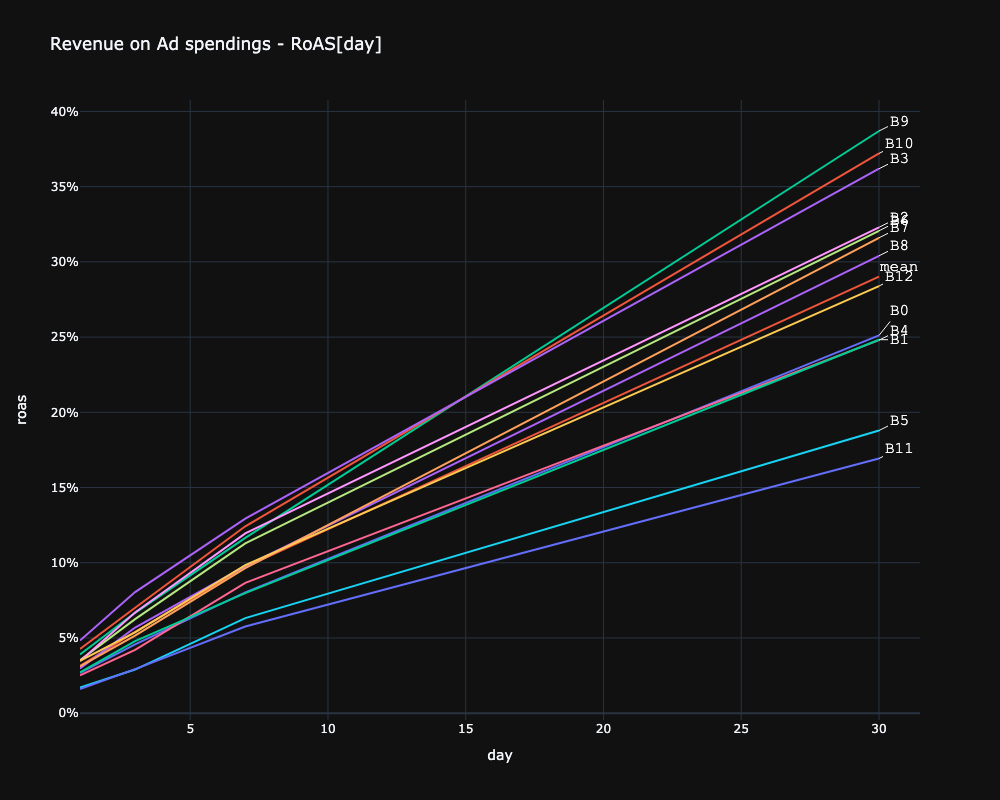

In [76]:
fig.show('png')

## CPA - cost per action

CPA[n] = CPI / C2P[n], где C2P[n] - доля пользователей, заплативших cколько угодно >0 в течение первых n дней игры

In [92]:
cpa = None
agg_func = {
    'feature_X': ('feature_X', 'first'),
    'cpi': ('cpi', 'first'),
    'revenue': ('revenue', 'sum')
}
days = [1, 3, 7, 30]
# days = range(1, 61)
for day in days:
    temp = df.loc[df.lifetime_per_buy_time <= day].groupby('id', as_index=False).agg(**agg_func)
    temp['is_paying'] = (temp['revenue'] > 0).astype(int)
    temp = temp.groupby('feature_X', as_index=False).agg(c2p=('is_paying', 'mean'), cpi=('cpi', 'mean'))
    temp['cpa'] = temp['cpi'] / temp['c2p']
    temp['day'] = day
    if cpa is None:
        cpa = temp
    else:
        cpa = pd.concat([cpa, temp])
# cpa.pivot(index='feature_X', columns='day', values='cpa')
fig = px.line(
    cpa.sort_values('day'),
    x='day', y='cpa', color='feature_X',
    title='Cost per Action - CPA[day]',
    template='plotly_dark',
    height=800, width=1000
)
annot = cpa.loc[cpa.day==30, ['feature_X', 'cpa']]
for feature in annot.feature_X.unique():
    fig.add_annotation(
        x=30,
        y=annot.loc[annot.feature_X == feature, 'cpa'].values[0],
        text=feature,
        align="center",
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#ffffff"
        ),
        ax=20,
        ay=-10
    )
fig.update_traces(textposition='top right')
fig.update_layout(showlegend=False)
pass

Метрика CPA отражает удельную стоимость привлечения платящей аудитории, поэтому чем ниже ее значение - тем дешевле канал привлечения, что повышает вероятность канала окупиться

Основные выводы на основе значений CPA[30 days]:
- Таким же образом, как RoAS, я разделил значения метрики для разных каналов на несколько групп:
    1. `Low-cost`: до 100$ на платящего пользователя - самые дешевые каналы привлечения, это `B3, B2, B5` и пограничный `B4`
    2. `Mid-cost`: от 100 до 150$ за платящего пользователя - самая многочисленная группа, все каналы в ней расположились очень плотно `B10, B11, B8, B12, B9, B6`
    3. `High-cost`: от 150$ на платящего пользователя - самые дорогие каналы: `B0, B1, B7`
- Основные факторы, влияющие на метрику:
    - Количество платящих пользователей - чем лучше пользователи конвертируются в платящих, тем ниже показатель CPA
    - Cost per install - стоимость привлечения пользователя в сегменте feature_X

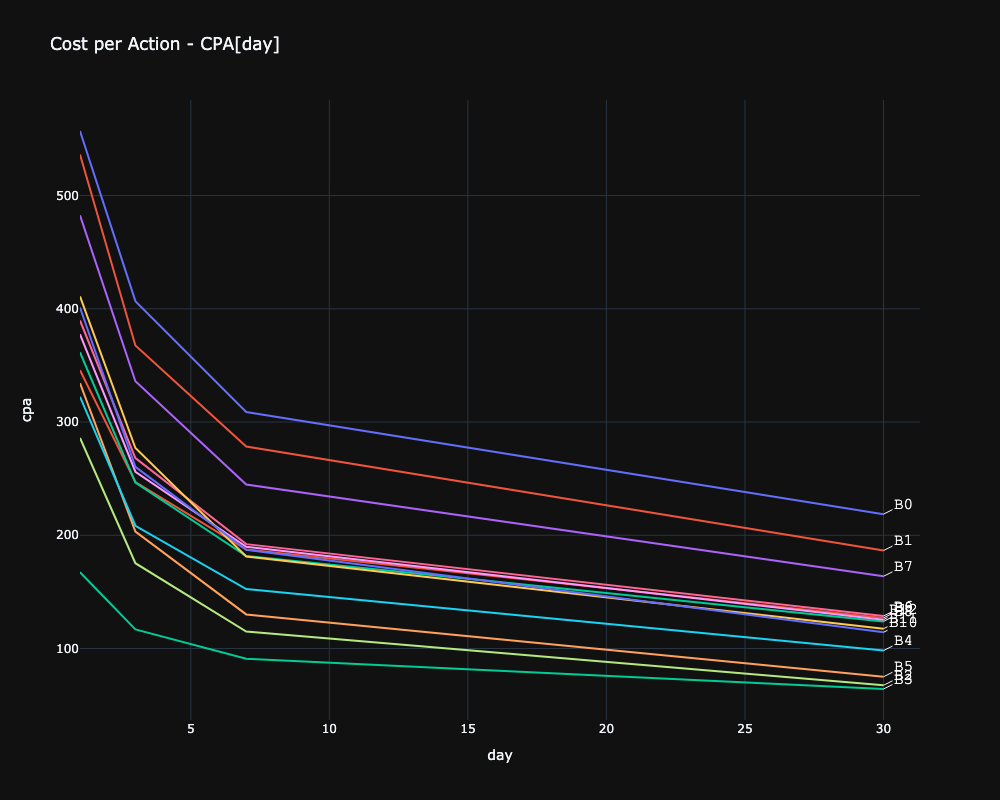

In [93]:
fig.show('png')

## Доля платящих

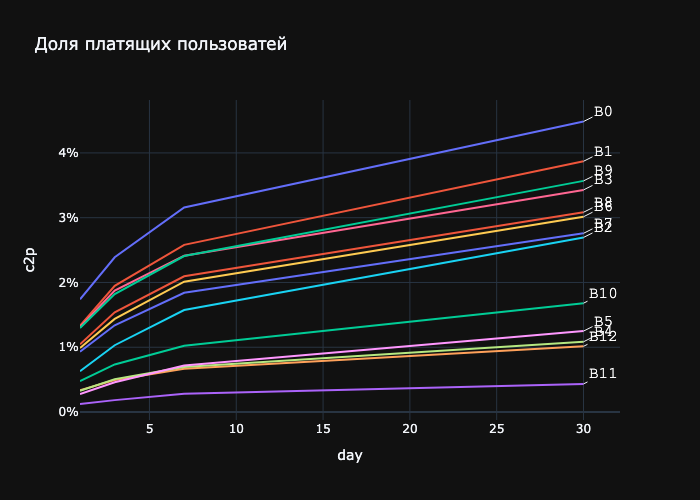

In [371]:
fig = px.line(
    cpa, x='day', y='c2p', color='feature_X',
    template='plotly_dark',
    title='Доля платящих пользоватей'
)
annot = cpa.loc[cpa.day==30, ['feature_X', 'c2p']]
for feature in annot.feature_X.unique():
    fig.add_annotation(
        x=30,
        y=annot.loc[annot.feature_X == feature, 'c2p'].values[0],
        text=feature,
        align="center",
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#ffffff"
        ),
        ax=20,
        ay=-10
    )
fig.update_layout(yaxis_tickformat=".0%")
fig.update_layout(showlegend=False)
fig.show('png')

## RoAS vs CPA


In [349]:
def matrix(roas, cpa, day):
    temp = roas.merge(
        cpa, on=['feature_X', 'day']
    )
    fig = px.scatter(
        temp.loc[temp.day==day],
        x='roas', y='cpa', text='feature_X', #color='feature_X',
        title=f'Матрица эффективности канала привлечения на основе метрик {day}-дней',
        template='plotly_dark'
    )
    fig.update_traces(textposition="top center",)
    fig.add_vrect(x0=0, x1=np.percentile(roas.loc[roas.day==day, 'roas'], 25), line_width=0, fillcolor="red", opacity=0.2)
    fig.add_vrect(x0=np.percentile(roas.loc[roas.day==day, 'roas'], 25), x1=np.percentile(roas.loc[roas.day==day, 'roas'], 75), line_width=0, fillcolor="yellow", opacity=0.2)
    fig.add_vrect(x0=np.percentile(roas.loc[roas.day==day, 'roas'], 75), x1=np.max(roas.loc[roas.day==day, 'roas'])+0.025, line_width=0, fillcolor="green", opacity=0.2)
    fig.add_hrect(y0=0, y1=np.percentile(cpa.loc[cpa.day==day, 'cpa'], 25), line_width=0, fillcolor="green", opacity=0.2)
    fig.add_hrect(y0=np.percentile(cpa.loc[cpa.day==day, 'cpa'], 25), y1=np.percentile(cpa.loc[cpa.day==day, 'cpa'], 75), line_width=0, fillcolor="yellow", opacity=0.2)
    fig.add_hrect(y0=np.percentile(cpa.loc[cpa.day==day, 'cpa'], 75), y1=np.max(cpa.loc[cpa.day==day, 'cpa'])+100, line_width=0, fillcolor="red", opacity=0.2)

    fig.update_yaxes(autorange="reversed")
    fig.update_layout(xaxis_tickformat=".1%")
    return fig

- По распределениям, описанным ранее в разборе метрик CPA и RoAS, я построил матрицу эффективности канала привлечения
- Самая высокая вероятность окупиться у канала `B3` - там самая низкая стоимость привлечения платящего пользователя и выручка на потраченную рекламу
- Другие три сегмента также имеют высокую вероятность окупиться - `B2` и `B10, B9`
- Самые худшие сегменты - `B11, B1`, далее я посчитаю прогноз окупаемости этих каналов и сверю их с выводами из матрицы, если второй метод подтвердит, то я буду рекомендовать существенно скорректировать работу с данными каналами привлечения
- Самый неоднозначный сегмент в данной матрицы `B0` - это самый многочисленный сегмент, при этом это и самый дорогой канал, но при этом там самая высокая доля платящих пользователей. Необходим дальнейший анализ окупаемости инвестиций в данный канал, чтобы принять решение
- Также вызывает вопросы сегмент `B5` - это один из самых дешевых каналов привлечения, но из-за низкой доли платящих пользователей он попадает в аутсайдеры, возможно здесь необходимы дополнительные усилия по увеличению доли платящих пользователей (скидки, коммуникации)

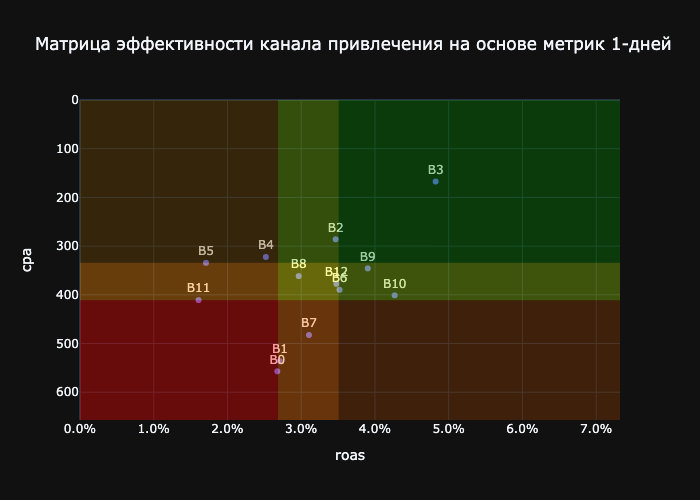

In [353]:
matrix(roas, cpa, 1).show('png')

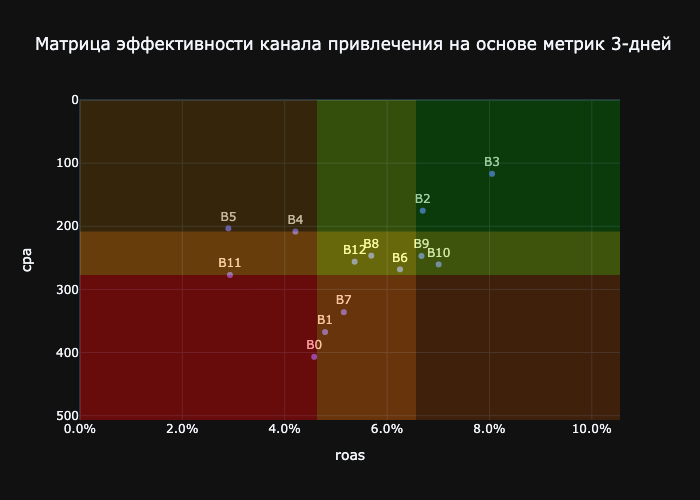

In [352]:
matrix(roas, cpa, 3).show('png')

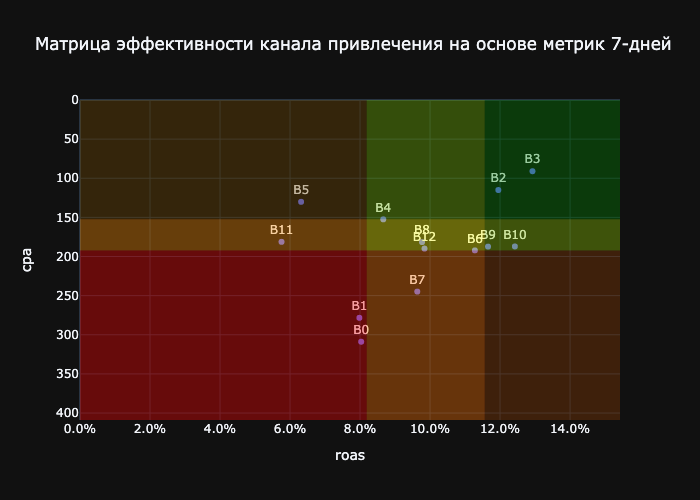

In [351]:
matrix(roas, cpa, 7).show('png')

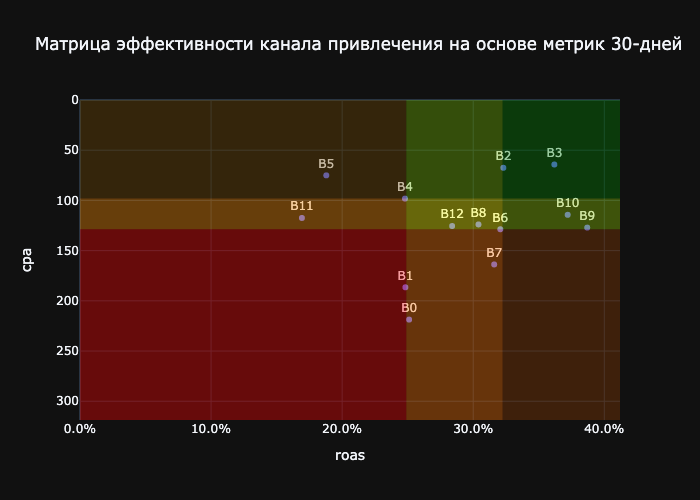

In [350]:
matrix(roas, cpa, 30).show('png')

# Прогноз RoAS

Для построения прогноза окупаемости каждого из каналов я воспользуюсь теорией выживаемости для прогноза **retention** платящих пользователей на каждом канале. Как я ранее писал, retention - это ключевая метрика, оказывающая влияние на RoAS, при этом доля платящих меняется день ото дня.

В данном разделе:
1) Я расчитаю функцию выживаемости для каждого канала и прогнозирую "выживаемость" платящих до 365-ый дня
2) Далее я рассчитаю **ARPPU (average revenue per paying user) - среднюю выручку с платящего пользователя за день** для каждого из каналов
3) Далее зная вероятность пользователя выжить на 365-ый день, количество платящих пользователь в 1-ый день и ARPPU, я смогу посчитать выручку за 365 дней
4) Зная выручку на 365 день, ее можно поделить на суммарный CPI (включая неплатящих) и получить оценку RoAS на 365 день
5) Финальный результат будет представлен в виде доверительного интервала RoAS с уровнем значимости 95%

Для данного подхода я задам определение платящего пользователя.

**Платящий пользователь** - это состояние пользователя на дату означающее, что в следующие 30 дней он произвел хотя бы одну покупку

Замечания по подходу: на самом деле метод построения функции выживаемости больше подходит под объяснения причин почему одни клиенты остаются на сервисе дольше чем другие, здесь я применяю экспоненциальную оценку как способ провалидировать результаты, полученные на матрице эффективности каналов привлечения. Метод моделирования retention через экспоненту не всегда точен и несет высокую погрешность.

## Функция выживаемости

In [157]:
agg_func = dict(
    feature_X = ('feature_X', 'first'),
    cpi = ('cpi', 'first'),
    reg_time = ('reg_time', 'first'),
    last_buy_time = ('buy_time', 'max'),
    revenue = ('revenue', 'sum'),
    transaction_count = ('buy_time', 'count')
)

lifeline = df.copy()#.loc[df.buy_time < df.buy_time.max() - timedelta(days=30)].copy()
lifeline = lifeline.groupby('id', as_index=False).agg(**agg_func)
lifeline['last_buy_time'] = lifeline['last_buy_time'].fillna(lifeline.reg_time - timedelta(days=1))
lifeline['day'] = (lifeline['last_buy_time'] - lifeline['reg_time']).dt.days.astype(int) + 1
lifeline['revenue_per_day'] = lifeline['revenue'] / lifeline['day']
lifeline['revenue_per_transaction'] = lifeline['revenue'] / lifeline['transaction_count']
lifeline['next_buy_time_to_be_paying'] = lifeline['last_buy_time'] + timedelta(days=30)
lifeline['revenue_per_day'] = lifeline['revenue_per_day'].fillna(0)
lifeline['is_churned'] = (lifeline['next_buy_time_to_be_paying'] < df.buy_time.max()).astype(int)
lifeline = lifeline.loc[lifeline.day > 0]

In [298]:
# Собранный датасет
lifeline[['id', 'feature_X', 'revenue', 'revenue_per_day', 'day', 'is_churned']].head()

,id,feature_X,revenue,revenue_per_day,day,is_churned
4,000030de0b52e478c151604e7b8c825d,B6,6.452560,1.290512,5,1
59,00044b96dc703d4736a5a167adc1a88f,B0,54.800000,1.074510,51,1
76,00063b7515cdf29f1168140420674e3c,B6,34.452666,0.291972,118,0
87,0006fc9532663071ad20773117bb218d,B0,22.960000,0.510222,45,1
104,0007dc571cb3ce40418cc5a2eb1735ee,B0,10.970000,0.249318,44,1


In [167]:
exp = ExponentialFitter()
result = None
t = range(366)
for i, feature in enumerate(lifeline.feature_X.unique()):
    X = lifeline.loc[lifeline.feature_X == feature, 'day']
    E = lifeline.loc[lifeline.feature_X == feature, 'is_churned']
    exp.fit(X, event_observed=E, timeline=range(0, 366), label=feature)
    temp = exp.confidence_interval_survival_function_
    temp = temp.merge(exp.survival_function_, left_index=True, right_index=True).reset_index()
    temp['feature_X'] = feature
    temp.rename({
        feature: 'retention',
        f'{feature}_lower_0.95':'retention_lower_0.95',
        f'{feature}_upper_0.95':'retention_upper_0.95',
        'index': 'day'
    }, axis=1, inplace=True)
    if result is None:
        result = temp
    else:
        result = pd.concat([result, temp])


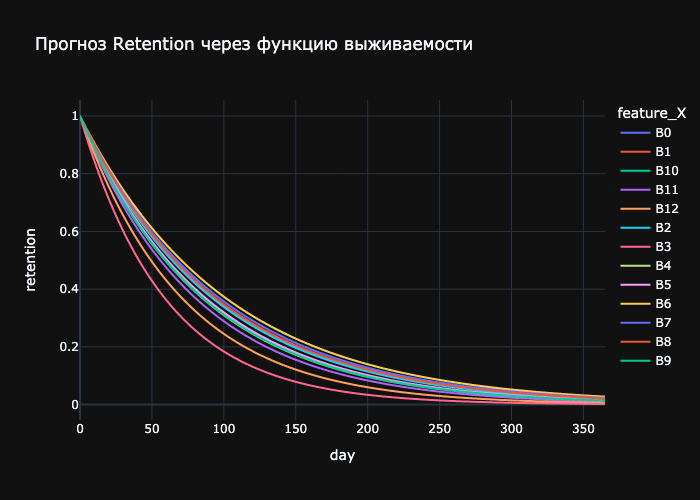

In [174]:
fig = px.line(
    result.sort_values(['feature_X', 'day']),
    x='day', y='retention', color='feature_X',
    template='plotly_dark',
    # log_y=True,
    title='Прогноз Retention через функцию выживаемости'
)
fig.show('png')
# fig.show()

## Оценка ARPPU

Поскольку ARPPU в данном случае случайная величина, значение ее среднего я рассчитаю с помощью bootstrap

In [367]:
arppu = {
    'feature_X': [],
    'ARPPU_low': [],
    'ARPPU_high': []
}
for feature in lifeline.feature_X.unique():
    data = (lifeline.loc[lifeline.feature_X == feature, 'revenue_per_day'].values, )
    bootstr = bootstrap(data, np.mean, n_resamples=len(data[0]))
    arppu['feature_X'].append(feature)
    arppu['ARPPU_low'].append(bootstr.confidence_interval.low)
    arppu['ARPPU_high'].append(bootstr.confidence_interval.high)
arppu = pd.DataFrame.from_dict(arppu)
arppu['ARPPU_mean'] = np.round((arppu['ARPPU_low'] + arppu['ARPPU_high'])/2, 2)
arppu['ARPPU_margin_error'] = arppu['ARPPU_mean'] - arppu['ARPPU_low']

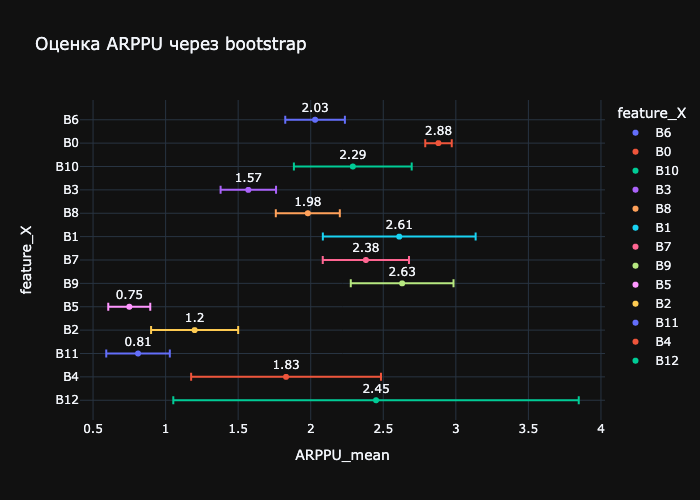

In [368]:
fig = px.scatter(
    arppu,
    x='ARPPU_mean', y='feature_X', error_x='ARPPU_margin_error',
    text='ARPPU_mean',
    color='feature_X',
    template='plotly_dark',
    title=f'Оценка ARPPU через bootstrap'
)
fig.update_traces(textposition="top center",)
fig.show('png')

## Прогноз RoAS

Расчет прогноза простой - перемножаем количество платящих пользователей на нижнюю границу интервала Retention и на нижнюю границу ARPPU, далее тоже самое для верхнего интервала. Полученную величину делю на фактический CPI канала.

In [356]:
days = 365
# Считаю сколько всего появилось платящих, а так же их средний ARPPU, как сумму всей выручки на количество дней до последней покупки
forecast = lifeline.groupby('feature_X', as_index=False).agg(paying_users=('id', 'count')) \
    .merge(result.loc[result.day<=days], on='feature_X')\
    .merge(arppu, on='feature_X')

forecast['revenue_forecast_lower_0.95'] = forecast['paying_users'] * forecast['ARPPU_low'] * forecast['retention_lower_0.95']
forecast['revenue_forecast_upper_0.95'] = forecast['paying_users'] * forecast['ARPPU_high'] * forecast['retention_upper_0.95']
forecast = forecast\
    .groupby('feature_X')[['revenue_forecast_lower_0.95', 'revenue_forecast_upper_0.95']].agg('sum')\
    .merge(users_df.groupby('feature_X')['cpi'].sum(), left_index=True, right_index=True).reset_index()

forecast['RoAS_lower_0.95'] = forecast['revenue_forecast_lower_0.95'] / forecast['cpi']
forecast['RoAS_upper_0.95'] = forecast['revenue_forecast_upper_0.95'] / forecast['cpi']
forecast['RoAS'] = (forecast['RoAS_lower_0.95'] + forecast['RoAS_upper_0.95'])/2
forecast['RoAS_margin_error'] = forecast['RoAS'] - forecast['RoAS_lower_0.95']
forecast['RoAS'] = np.round(forecast['RoAS'], 2)

In [357]:
fig = px.scatter(
    forecast.reset_index().sort_values('RoAS', ascending=False),
    x='RoAS', y='feature_X', error_x='RoAS_margin_error',
    text='RoAS',
    color='feature_X',
    template='plotly_dark',
    title=f'Прогноз RoAS[{days} days]'
)
fig.add_vline(x=1)
fig.update_traces(textposition="top center",)
pass

Ниже график с результатами моделирования RoAS[365 days] с помощью метода выживаемости, основные выводы:
- Не окупающиеся каналы: `B12, B5, B11`
- По `B0` ситуация стала более ясной - доверительный интервал лежит дальше 1, наиболее вероятно, что он покажет результат по RoAS > 1

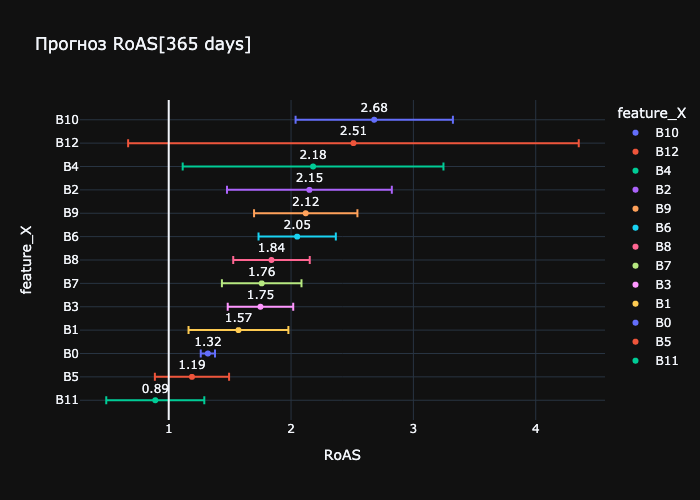

In [358]:
fig.show('png')